# Document clustering

Lets get started...

In order to classify the items based on their content, I decided to use K- means algorithm. Due to the fact the the items are un-labeled , it is clearly a unsupervised learning problem and one of the best solution should be K-Means. Of course we can use a different algorithm, such as Gaussian mixture models or even deep learning methods such as Autoencoders. I will use python with Jupyter notebook, to combine the code and the results with the documentation.

I develope the code in Anaconda environment and i use the following dependencies:

Pandas for data handing

Sklearn for machine learning and preprocessing

Matplotlib for plotting

Ntlk for natural language algorithms

BeautifulSoup to parse the text from xml file and get rid of the tags



### Parsing the Data

The function parseXML uses the xml.etree.ElementTree to parse the data. I decided to use only the title and the description of the items for the clustering, which are the most relevant to semasiology. Because of the fact that the description is not raw tex , we extract the text with the BeautifulSoup library, as I already mention. Also we drop the items with a very small description , because they affect the final clustering. We can consider that they all belong to an extra cluster. Of course, there are ways to include them, but I do not use them for the moment. 


In [20]:
import xml.etree.ElementTree as ET
import pandas as pd

import nltk
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
from bs4 import BeautifulSoup
from nltk import SnowballStemmer
import re

def parseXML(xmlfile):

    tree = ET.parse(xmlfile)
    root = tree.getroot()

    titles=[]
    descriptions=[]

    for item in root.findall('./channel/item'):

        for child in item:
     
            if(child.tag=='title' ):
                titles.append(child.text)

            if (child.tag == 'description' ):

                soup = BeautifulSoup(str(child.text).encode('utf8','ignore'), "lxml")
                strtext=soup.text.replace(u'\xa0', u' ').replace('\n',' ')
                            
                descriptions.append(strtext)
                    
    return titles,descriptions

#remove items with short descriptions
bef_titles,bef_descriptions = parseXML('data.source.rss-feeds.xml')
print('Count of items before dropping:' ,len(bef_titles))

titles=[]
descriptions=[]
for i in range(len(bef_titles)):
    
    if ( len(bef_descriptions[i]) > 500):
        titles.append(bef_titles[i])
        descriptions.append(bef_descriptions[i])

print('Count of items after:' ,len(titles))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sergi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Count of items before dropping: 1662
Count of items after: 1130


### Tokenizing and stemming 

The next step is to tokenize the text into words,remove any morphological affixes and drop common words such as articles and prepositions.This can be done with built-in functions of ntlk.I  the end, we get two distinct vocabularies(one tokenized andstemmed and one only tokenized ) and we combine them to a pandas dataframe.

In [28]:
def tokenize_and_stem(text):
    
    #tokenize
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    #keep only letters
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
   
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [3]:
# nltk's English stopwords and stemmer
stemmer = SnowballStemmer("english")

#create steam and tokenized voucabularies
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in descriptions:
    allwords_stemmed = tokenize_and_stem(i)  
    totalvocab_stemmed.extend(allwords_stemmed)  

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index=totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 481437 items in vocab_frame


### Vectorizing and stemming

Before we load the data into the K- means algorithm , it is essential to vectorize them. The most popular technique is Tdidf Vectorizer, which create a matrix based on the frequency of words in the documents and this is the one we are going to use. Basically, it shows how important is a word to a document .It is worth to mention that, as a future work word2vec and doc2vec may be a much more efficient to represent the relationships between the items.

In [4]:
#Tf-idf


tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions) 
print('Td idf Matrix shape: ',tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

#calculate the distance matrix . I will use them in the visualization of the cluster.
dist = 1 - cosine_similarity(tfidf_matrix)


Td idf Matrix shape:  (1130, 74)


### K means

The actual clustering takes place here, where K means produces 5 clusters based on the Td-idf matrix. We can easily predict that this will not be the optimal solution, cause it takes into consideration only the frequency of each word in the document.

In [5]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

To present the cluster, i create a pandas Dataframe indexed by the clusters. The top 6 words of each cluster are presented below. We notice that the clustering is far from perfect as some words are in more than one cluster. Also there isn't a clear distinction between the semantic content of clusters. We can easily see that terms related to work includes in more that one clusters.

In [18]:
items = { 'title': titles, 'description': descriptions}

frame = pd.DataFrame(items, index = [clusters] , columns = [ 'title','cluster'])


print("Top terms per cluster:")

# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')

    for ind in order_centroids[i, :6]:  # replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        
        
    print()    
    
    #print("Cluster %d titles:" % i, end='')
    #for title in frame.ix[i]['title'].values.tolist():
       #print(' %s,' % title, end='')

   


Top terms per cluster:
Cluster 0 words: labour, employability, european, social, work, eu,
Cluster 1 words: occupational, sectors, skill, employability, services, workers,
Cluster 2 words: skill, job, labour, develop, market, cedefop,
Cluster 3 words: education, training, learning, vocational, education, cedefop,
Cluster 4 words: rates, unemployment, area, employability, increasingly, stated,


### Visualization

To visualize the clustering , we should first reduce their dimensionality. We achieved that with t-SNE(t-Distributed Stochastic Neighbor Embedding) from sklearn.manifold library. Another way would pe to use PCA or Multi-Demiensional Scaling(MDS). 

The plotting is done with matplotlib library.



In [7]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# dist is the distance matrix 
pos = tsne.fit_transform(dist)  

xs, ys = pos[:, 0], pos[:, 1]


cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'A',1: 'B',  2: 'C', 3: 'D',  4: 'E'}

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1130
[t-SNE] Computed conditional probabilities for sample 1130 / 1130
[t-SNE] Mean sigma: 1.785805
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.947952
[t-SNE] Error after 125 iterations: 0.947952


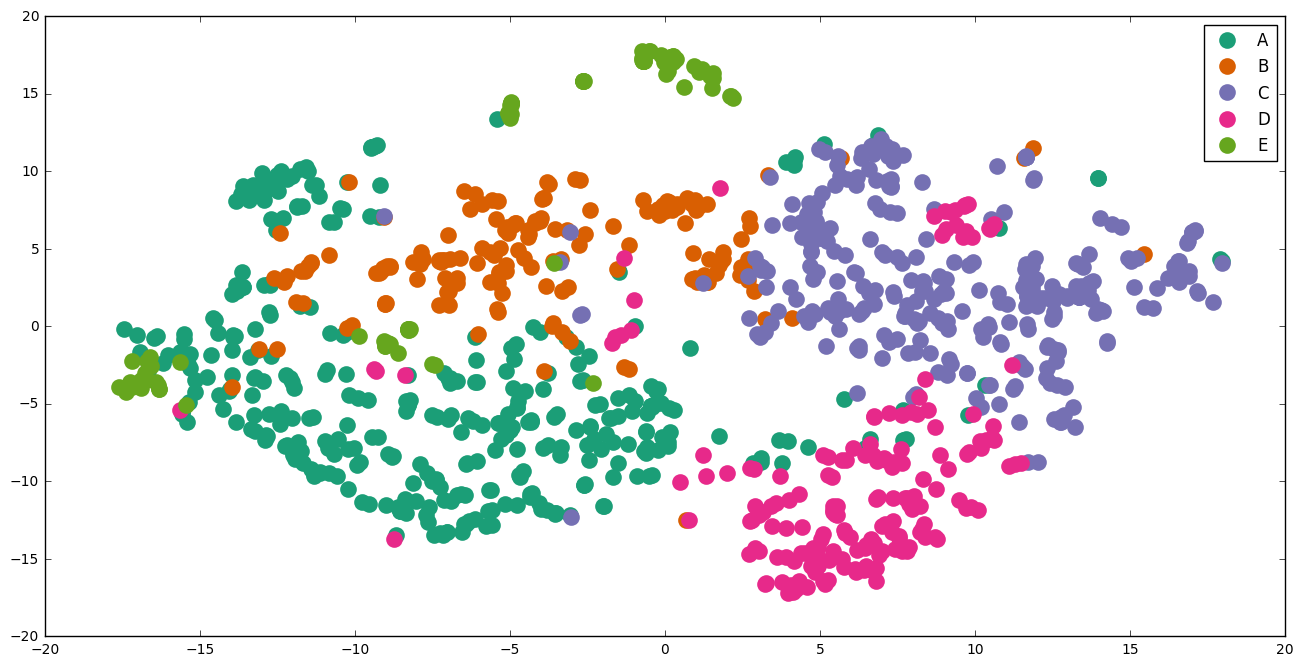

In [23]:
%matplotlib inline 

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(16,8) )


for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
    
        
ax.legend(numpoints=1)  

#we do not present the tiles of items to not make the graph overwhelming
#for i in range(len(df)):
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=4)  

    
plt.show()


We observe that the results are not as bad as we initially thought.  Although there is some partial overlapping, the groups are quite distinguished. There is no doubt, however, that we can optimize them much further. 

We should mention that items with a few words are not presented in the graph . I also notice that there are some items written in a differenet laguage than English. We currently not handle them and as a result their classification is in fact random. There are some of the misplaced dots in the diagramm.

Moreover, there is more work to be done with the data cleaning and preprocessing. 

One way is to optimize the parameters of tdidf vectorization, use [doc2vec](https://arxiv.org/abs/1405.4053) for vectorization . Or we can use an another technique such Affinity Propagation,Spectral Clustering or more recent methods like HDBSCAN and [Variational Autoencoders](https://arxiv.org/abs/1611.05148), which i would love to develop.

PS: To run the code, you can do it directly from jupyter if the required dependencies are installed or you can export it as .py file and run it with an ide or directly via the console. 